In [2]:
import pandas as pd
import keras
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 9,6

from keras.datasets import cifar10

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU

from keras import backend as K
from keras import applications
from keras import callbacks
from keras import optimizers
from keras.utils import np_utils
import random
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings(action='ignore')

# <span style='font-family:Georgia'> Data loading & preparation

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

BATCH_SIZE = 32
INPUT_SHAPE = X_train.shape[1:]
NUM_CLASSES=10

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [4]:
# Normalize input data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Convert class labels to one-hot encoded
y_train = keras.utils.np_utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.np_utils.to_categorical(y_test, NUM_CLASSES)

# <span style='font-family:Georgia'> Fitting the Deep Learning Models

In [5]:
LR=1e-3 # chosen base on tuning performed in the modelling notebook
EPOCHS=100  
PATIENCE=10
MIN_DELTA=0.01
early_stop = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, min_delta=MIN_DELTA)

In [6]:
# Data augmentation - 2 different approaches

datagen1 = ImageDataGenerator(
    zca_epsilon=1e-06,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)
datagen1.fit(X_train)

datagen2 = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
datagen2.fit(X_train)

## <span style='font-family:Georgia'> Model concept no. 1

In [7]:
def generate_model1(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (1).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters = 16, kernel_size = (3, 3), padding='same', input_shape=INPUT_SHAPE))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding='same'))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation("softmax"))
    
    model.compile(
        loss='categorical_crossentropy',  
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
        metrics=['accuracy']
    )
    
    return model

In [9]:
model1_stats = []
model1_aug1_stats = []
model1_aug2_stats = []
model1_acc = []
model1_aug1_acc = []
model1_aug2_acc = []
for i in range(5):
    model1 = generate_model1()
    model1_history = (model1.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
        callbacks=[early_stop],shuffle=True,verbose=1,validation_data=(X_test, y_test_ohe)))
    model1_stats.append(model1_history)

    model1_aug1 = generate_model1()
    model1_aug1_history = (model1_aug1.fit(datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1))
    model1_aug1_stats.append(model1_aug1_history)
    
    model1_aug2 = generate_model1()
    model1_aug2_history = (model1_aug2.fit(datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1)) 
    model1_aug2_stats.append(model1_aug2_history)

    y_pred_1 = model1.predict(X_test)
    y_pred_1_aug1 = model1_aug1.predict(X_test)
    y_pred_1_aug2 = model1_aug2.predict(X_test)
    y_pred_classes_1 = np.argmax(y_pred_1, axis=-1)
    y_pred_classes_1_aug1 = np.argmax(y_pred_1_aug1, axis=-1)
    y_pred_classes_1_aug2 = np.argmax(y_pred_1_aug2, axis=-1)
    model1_acc.append(accuracy_score(y_test, y_pred_classes_1))
    model1_aug1_acc.append(accuracy_score(y_test, y_pred_classes_1_aug1))
    model1_aug2_acc.append(accuracy_score(y_test, y_pred_classes_1_aug2))


Epoch 1/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.4119 - accuracy: 0.4894 - val_loss: 1.0278 - val_accuracy: 0.6337
Epoch 2/100
1563/1563 [==============================] - 45s 29ms/step - loss: 0.9839 - accuracy: 0.6538 - val_loss: 0.8255 - val_accuracy: 0.7113
Epoch 3/100
1563/1563 [==============================] - 46s 29ms/step - loss: 0.8409 - accuracy: 0.7057 - val_loss: 0.7501 - val_accuracy: 0.7397
Epoch 4/100
1563/1563 [==============================] - 48s 31ms/step - loss: 0.7606 - accuracy: 0.7333 - val_loss: 0.7255 - val_accuracy: 0.7438
Epoch 5/100
1563/1563 [==============================] - 44s 28ms/step - loss: 0.7022 - accuracy: 0.7538 - val_loss: 0.6943 - val_accuracy: 0.7605
Epoch 6/100
1563/1563 [==============================] - 46s 29ms/step - loss: 0.6619 - accuracy: 0.7684 - val_loss: 0.6617 - val_accuracy: 0.7681
Epoch 7/100
1563/1563 [==============================] - 44s 28ms/step - loss: 0.6207 - accuracy: 0.7808 - val_loss: 0

### <span style='font-family:Georgia'> Model no 1. results summary

In [17]:
# TODO tabelka
model1_acc_results = pd.DataFrame([model1_acc, model1_aug1_acc, model1_aug2_acc]).T
model1_acc_results.columns=['model1', 'model1_aug1', 'model1_aug2']
model1_acc_results.describe().T[['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
model1,5.0,3.0,1.581139,1.0,5.0
model1_aug1,5.0,8.0,1.581139,6.0,10.0
model1_aug2,5.0,13.0,1.581139,11.0,15.0


## <span style='font-family:Georgia'> Model concept no. 2

In [13]:
def generate_model2(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (2).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=INPUT_SHAPE, activation='relu', padding = 'same', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
              metrics=['accuracy'])
    
    return model    

In [ ]:
model2_stats = []
model2_aug1_stats = []
model2_aug2_stats = []
model2_acc = []
model2_aug1_acc = []
model2_aug2_acc = []
for i in range(5):
    model2 = generate_model2()
    model2_history = (model2.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
        callbacks=[early_stop],shuffle=True,verbose=1,validation_data=(X_test, y_test_ohe)))
    model2_stats.append(model2_history)
    model2_aug1 = generate_model2()
    model2_aug1_history = (model2_aug1.fit(datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1))
    model2_aug1_stats.append(model2_aug1_history)
    model2_aug2 = generate_model2()
    model2_aug2_history = (model2_aug2.fit(datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1)) 
    model2_aug2_stats.append(model2_aug2_history)         

    y_pred_2 = model2.predict(X_test)
    y_pred_2_aug1 = model2_aug1.predict(X_test)
    y_pred_2_aug2 = model2_aug2.predict(X_test)
    y_pred_classes_2 = np.argmax(y_pred_2, axis=-1)
    y_pred_classes_2_aug1 = np.argmax(y_pred_2_aug1, axis=-1)
    y_pred_classes_2_aug2 = np.argmax(y_pred_2_aug2, axis=-1)
    model2_acc.append(accuracy_score(y_test, y_pred_classes_2))
    model2_aug1_acc.append(accuracy_score(y_test, y_pred_classes_2_aug1))
    model2_aug2_acc.append(accuracy_score(y_test, y_pred_classes_2_aug2))


### <span style='font-family:Georgia'> Model no 2. results summary

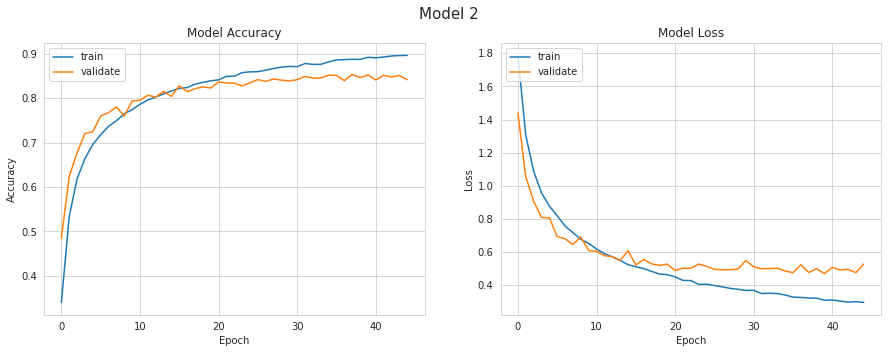

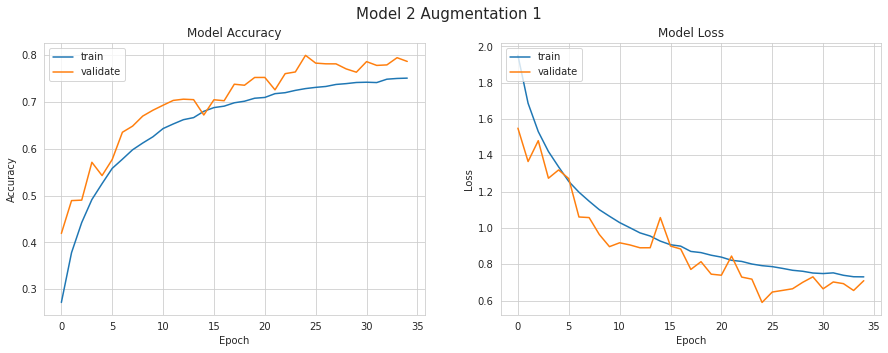

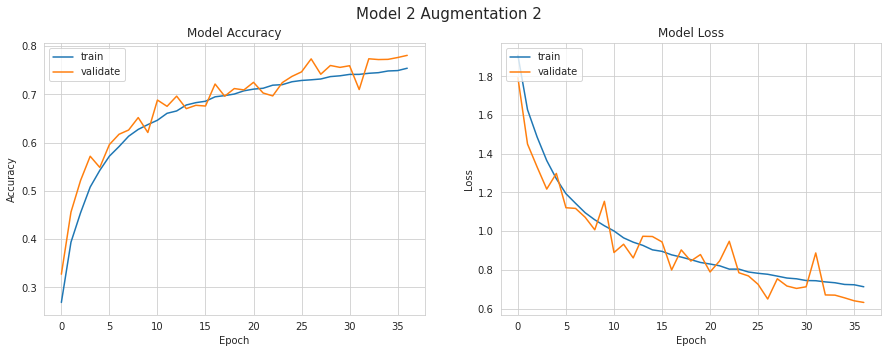

In [19]:
# TODO tabelka
model2_acc_results = pd.DataFrame([model2_acc, model2_aug1_acc, model2_aug2_acc]).T
model2_acc_results.columns=['model2', 'model2_aug1', 'model2_aug2']
model2_acc_results.describe().T[['count', 'mean', 'std', 'min', 'max']]

## <span style='font-family:Georgia'> Model concept no. 3

In [20]:
def generate_model3(learning_rate: float = LR):
    """
    Generate Keras Sequential model according to proposed architecture (3).

    Args:
        learning_rate (float, optional): Learning rate of the neural network. Defaults to LR.

    Returns:
        Keras Sequential model, complied, ready to use (to call .fit method).
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=INPUT_SHAPE, activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu',))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, decay=1e-6), 
               metrics=['accuracy'])
    
    return model

In [ ]:
model3_stats = []
model3_aug1_stats = []
model3_aug2_stats = []
model3_acc = []
model3_aug1_acc = []
model3_aug2_acc = []
for i in range(5):
    model3 = generate_model3()
    model3_history = (model3.fit(X_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,
        callbacks=[early_stop],shuffle=True,verbose=1,validation_data=(X_test, y_test_ohe)))
    model3_stats.append(model3_history)
    model3_aug1 = generate_model3()
    model3_aug1_history = (model3_aug1.fit(datagen1.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1))
    model3_aug1_stats.append(model3_aug1_history)
    model3_aug2 = generate_model3()
    model3_aug2_history = (model3_aug2.fit(datagen2.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,validation_data=(X_test, y_test_ohe),callbacks=[early_stop],workers=4,verbose=1)) 
    model3_aug2_stats.append(model3_aug2_history)         

    y_pred_3 = model3.predict(X_test)
    y_pred_3_aug1 = model3_aug1.predict(X_test)
    y_pred_3_aug2 = model3_aug2.predict(X_test)
    y_pred_classes_3 = np.argmax(y_pred_3, axis=-1)
    y_pred_classes_3_aug1 = np.argmax(y_pred_3_aug1, axis=-1)
    y_pred_classes_3_aug2 = np.argmax(y_pred_3_aug2, axis=-1)
    model3_acc.append(accuracy_score(y_test, y_pred_classes_3))
    model3_aug1_acc.append(accuracy_score(y_test, y_pred_classes_3_aug1))
    model3_aug2_acc.append(accuracy_score(y_test, y_pred_classes_3_aug2))

### <span style='font-family:Georgia'> Model no. 3 results summary

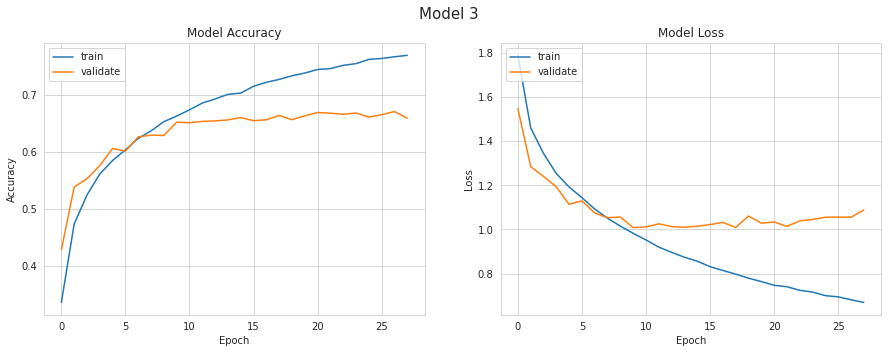

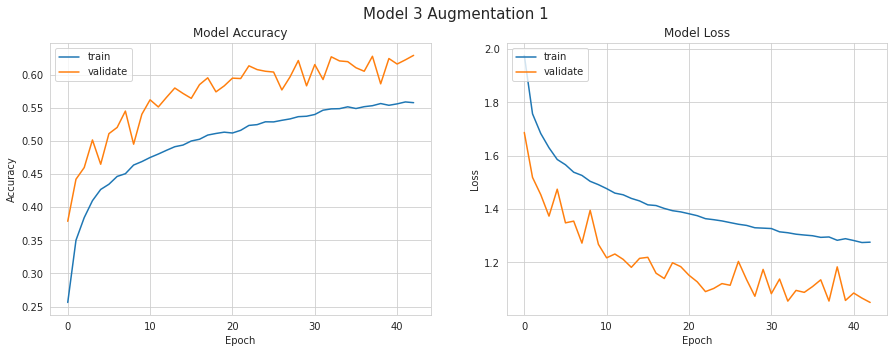

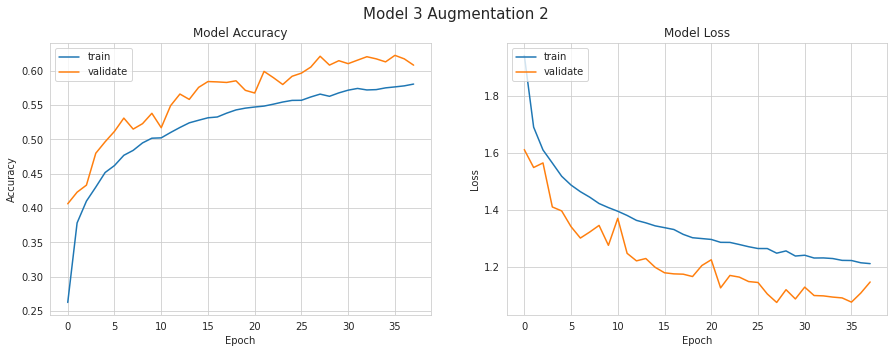

In [25]:
# TODO tabelka
model3_acc_results = pd.DataFrame([model3_acc, model3_aug1_acc, model3_aug2_acc]).T
model3_acc_results.columns=['model3', 'model3_aug1', 'model3_aug2']
model3_acc_results.describe().T[['count', 'mean', 'std', 'min', 'max']]

# <span style='font-family:Georgia'> Tuning hyperparameters (learning rate)

In [27]:
results_acc = pd.DataFrame(acc_all)
results_acc.columns = ['1', '2', '3']
results_acc.index = learning_rate
results_acc.index.name = "Learning rate"
results_acc_melted = pd.melt(results_acc.reset_index(), id_vars=['Learning rate'], value_vars=['1', '2', '3'])
results_acc_melted.columns=['Learning rate', 'Model', 'Accuracy']
results_acc.reset_index(inplace=True)

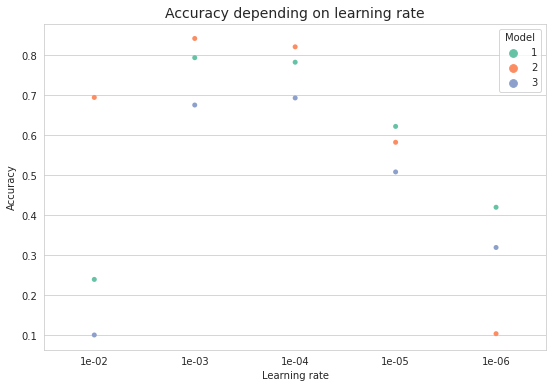

In [28]:
for j in range(results_acc_melted.shape[0]):
    results_acc_melted.loc[j, 'Learning rate'] = '{:.0e}'.format(results_acc_melted.loc[j, 'Learning rate'])
sns.stripplot(x="Learning rate", y="Accuracy", hue="Model",
               data=results_acc_melted, palette="Set2", dodge=False, jitter=0.0)    
plt.title("Accuracy depending on learning rate", size=14);

## <span style='font-family:Georgia'> Experiments results summary

In [30]:
best_lr_results = []
lr_best_index = 1
lr_best_3_index = 2
for i in range(3):
    if i==2: lr_index = lr_best_3_index 
    else: lr_index=lr_best_index
    train_acc = models_history[i][lr_index].history['accuracy'][-1]
    test_acc = models_history[i][lr_index].history['val_accuracy'][-1]
    train_loss = models_history[i][lr_index].history['loss'][-1]
    test_loss = models_history[i][lr_index].history['val_loss'][-1]
    model_stats = [train_acc, test_acc, train_loss, test_loss]
    best_lr_results.append(model_stats)
pd.DataFrame(best_lr_results, columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss'], index=['Model 1', 'Model 2', 'Model 3'])

,train_accuracy,test_accuracy,train_loss,test_loss
Model 1,0.86160,0.7937,0.390343,0.688905
Model 2,0.87506,0.8418,0.351098,0.504412
Model 3,0.75052,0.6930,0.737433,0.905251


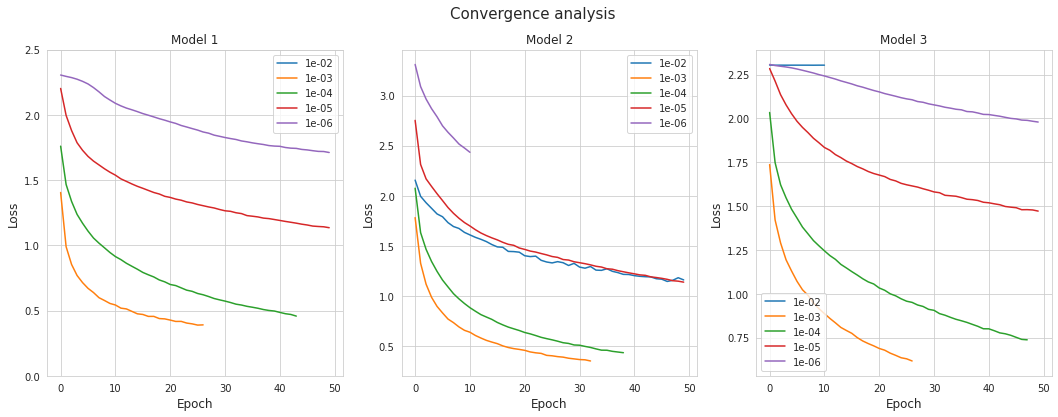

In [34]:
fig, axes = plt.subplots(1,3,figsize=(18,6))
models = ['1', '2', '3']
for i in range(3):
    model_name=models[i]
    history = models_history[i]
    for j, history_lr in enumerate(history):
        data_lr = history_lr.history['loss']
        sns.lineplot(data=data_lr, ax=axes[i], label='{:.0e}'.format(learning_rate[j]))
        if i == 0 : axes[i].set_ylim([0,2.5]) # due to huge loss values for 1e-2, to make other lines visible
        axes[i].set_title('Model '+model_name)
        axes[i].set_xlabel('Epoch', size=12)
        axes[i].set_ylabel('Loss', size=12)
fig.suptitle("Convergence analysis", size=15)
plt.show()